In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torch.utils.data import random_split,DataLoader
from torchvision.utils import make_grid
import torchvision.transforms  as transfroms
from torchvision.transforms import ToTensor

In [3]:
dataset = CIFAR100(root = './',train=True,transform=ToTensor(),download=True)
test_ds = CIFAR100('./',train=False,transform=ToTensor(),download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(len(dataset))
print(len(test_ds))

50000
10000


In [5]:
classes = dataset.classes
print("num classes :",len(classes))
print(classes)

num classes : 100
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whal

torch.Size([3, 32, 32])
19
cattle


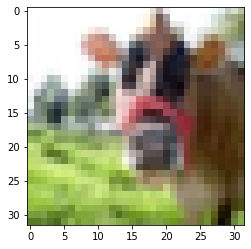

In [6]:
image,labels = dataset[0]
print(image.shape)
print(labels),print(dataset.classes[labels])
plt.imshow(image.permute(1,2,0))

# Dataset and Dataloader

In [7]:
valid_split  = 0.2
val_size = int(len(dataset) * valid_split)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [8]:
batch_size = 128
train_loader = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)
test_loader = DataLoader(test_ds,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)

# Visualising a batch of image

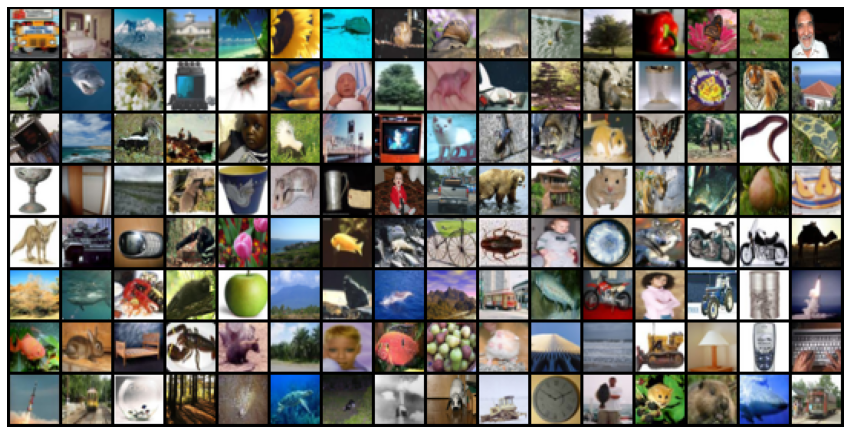

In [9]:
for images,labels in train_loader:
  plt.subplots(figsize=(15, 20))
  plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
  plt.axis('off')
  break

# Building The model

In [10]:
def accuracy(outputs,labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Image_Classification_Base(nn.Module):

  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_losses = [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}],train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['train_loss'], result['val_loss'], result['val_acc']))

In [11]:
input_shape = 32*32*3
num_classes = 100

In [12]:
class Cifar100_FeedForward(Image_Classification_Base):

  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(input_shape,64)
    self.linear2 = nn.Linear(64,128)
    self.linear3 = nn.Linear(128,256)
    self.linear4 = nn.Linear(256,512)
    self.linear5 = nn.Linear(512,1024)
    self.linear6 = nn.Linear(1024,num_classes)

  def forward(self,xb):
    out = self.flatten(xb)
    out = self.linear1(out)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    out = F.relu(out)
    out = self.linear5(out)
    out = F.relu(out)
    out = self.linear6(out)
    return out

In [13]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)


def  fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(),lr)
  optimizer.zero_grad()
  for epoch in range(epochs):
    model.train()
    train_loss = []
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      train_loss.append(loss)
    result = evaluate(model,val_loader)
    train_losses = torch.stack(train_loss).mean()
    result['train_loss'] = train_losses.item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

# Using GPU

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [17]:
model = to_device(Cifar100_FeedForward(), device)

In [18]:
evaluate(model, val_loader)

{'val_acc': 0.011768195778131485, 'val_loss': 4.605388641357422}

# Training the model

In [19]:
history = fit(10,0.001, model, train_loader, val_loader, opt_func=torch.optim.Adam)

Epoch [0],train_loss: 4.2618, val_loss: 4.0656, val_acc: 0.0670
Epoch [1],train_loss: 3.9284, val_loss: 3.8743, val_acc: 0.0990
Epoch [2],train_loss: 3.8279, val_loss: 3.8498, val_acc: 0.0963
Epoch [3],train_loss: 3.7803, val_loss: 3.8125, val_acc: 0.1045
Epoch [4],train_loss: 3.7607, val_loss: 3.7805, val_acc: 0.1082
Epoch [5],train_loss: 3.7249, val_loss: 3.7935, val_acc: 0.1111
Epoch [6],train_loss: 3.7175, val_loss: 3.7617, val_acc: 0.1140
Epoch [7],train_loss: 3.6980, val_loss: 3.7882, val_acc: 0.1094
Epoch [8],train_loss: 3.6777, val_loss: 3.7608, val_acc: 0.1188
Epoch [9],train_loss: 3.6610, val_loss: 3.7858, val_acc: 0.1152


In [20]:
history += fit(10,0.001, model, train_loader, val_loader, opt_func=torch.optim.Adam)

Epoch [0],train_loss: 3.6618, val_loss: 3.7747, val_acc: 0.1083
Epoch [1],train_loss: 3.6431, val_loss: 3.7633, val_acc: 0.1174
Epoch [2],train_loss: 3.6268, val_loss: 3.7581, val_acc: 0.1176
Epoch [3],train_loss: 3.6176, val_loss: 3.7889, val_acc: 0.1085
Epoch [4],train_loss: 3.6091, val_loss: 3.7540, val_acc: 0.1168
Epoch [5],train_loss: 3.5951, val_loss: 3.7627, val_acc: 0.1218
Epoch [6],train_loss: 3.5842, val_loss: 3.7540, val_acc: 0.1187
Epoch [7],train_loss: 3.5741, val_loss: 3.7759, val_acc: 0.1162
Epoch [8],train_loss: 3.5615, val_loss: 3.7724, val_acc: 0.1174
Epoch [9],train_loss: 3.5612, val_loss: 3.7657, val_acc: 0.1190


In [21]:
history += fit(20,0.001, model, train_loader, val_loader, opt_func=torch.optim.Adam)

Epoch [0],train_loss: 3.5598, val_loss: 3.7793, val_acc: 0.1169
Epoch [1],train_loss: 3.5366, val_loss: 3.7684, val_acc: 0.1218
Epoch [2],train_loss: 3.5209, val_loss: 3.7664, val_acc: 0.1225
Epoch [3],train_loss: 3.5172, val_loss: 3.8013, val_acc: 0.1154
Epoch [4],train_loss: 3.5027, val_loss: 3.8067, val_acc: 0.1160
Epoch [5],train_loss: 3.4927, val_loss: 3.8183, val_acc: 0.1208
Epoch [6],train_loss: 3.4840, val_loss: 3.8623, val_acc: 0.1160
Epoch [7],train_loss: 3.4720, val_loss: 3.8450, val_acc: 0.1143
Epoch [8],train_loss: 3.4599, val_loss: 3.8756, val_acc: 0.1172
Epoch [9],train_loss: 3.4605, val_loss: 3.8282, val_acc: 0.1188
Epoch [10],train_loss: 3.4481, val_loss: 3.8439, val_acc: 0.1250
Epoch [11],train_loss: 3.4312, val_loss: 3.8651, val_acc: 0.1176
Epoch [12],train_loss: 3.4167, val_loss: 3.8505, val_acc: 0.1218
Epoch [13],train_loss: 3.4172, val_loss: 3.8743, val_acc: 0.1174
Epoch [14],train_loss: 3.4001, val_loss: 3.9101, val_acc: 0.1122
Epoch [15],train_loss: 3.3916, val_

# Plotting Accuracy and Losses

In [22]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [23]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

# Evaluate the model on test data

In [24]:
evaluate(model, test_loader)

{'val_acc': 0.1207476258277893, 'val_loss': 3.932842493057251}